## Boosting with XGBoost

Fitting 1 folds for each of 20 candidates, totalling 20 fits
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=0.1, subsample=0.9; total time=  41.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=10, n_estimators=1000, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time= 2.1min
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=10, n_estimators=1000, reg_alpha=1, reg_lambda=0, subsample=0.9; total time= 2.1min
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=5, n_estimators=200, reg_alpha=0, reg_lambda=0.01, subsample=0.9; total time=  27.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05,

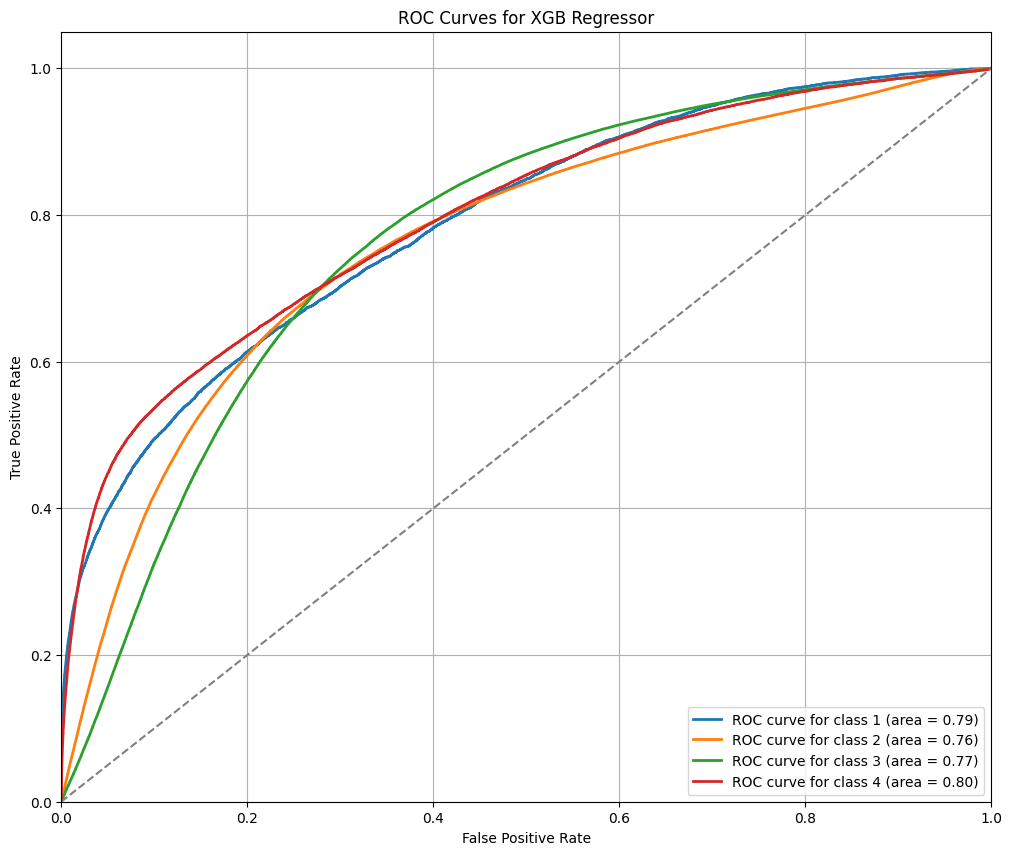

C:\Users\amrut\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGB Regression - MAE: 0.32423817254279974
XGB Regression - MSE: 0.341027557718064
Accuracy: 0.6841
R-squared (R²): -0.4581
Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.14      0.20      9362
           2       0.91      0.70      0.79    873568
           3       0.33      0.74      0.46    188164
           4       0.50      0.12      0.19     27219
           5       0.00      0.00      0.00         0

    accuracy                           0.68   1098313
   macro avg       0.43      0.34      0.33   1098313
weighted avg       0.79      0.68      0.71   1098313



C:\Users\amrut\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\amrut\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.preprocessing import label_binarize
from scipy.special import softmax

train_data = pd.read_csv("Train_Set.csv")
val_data = pd.read_csv("Validation_Set.csv")
test_data = pd.read_csv('Test_Set.csv')

X = train_data.drop(columns=["Severity"])
y = train_data["Severity"]

X_test = test_data.drop(columns=["Severity"])
y_test = test_data["Severity"]

combined_data = pd.concat([train_data, val_data], axis=0)
X_combined = combined_data.drop(columns=["Severity"])
y_combined = combined_data["Severity"]

# Create an indicator array for the validation set split
split_index = [-1] * len(train_data) + [0] * len(val_data)
predefined_split = PredefinedSplit(test_fold=split_index)

xgb_param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 10],
    'subsample': [0.6, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.01, 0.1, 1, 10],
    'reg_lambda': [0, 0.01, 0.1, 1, 10]
}

model_xgb_cv = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_distributions= xgb_param_grid,
    n_iter= 20,
    n_jobs= 1,
    cv = predefined_split,
    scoring= 'neg_mean_squared_error',
    error_score='raise',
    verbose=2
)

model_xgb_cv.fit(X_combined, y_combined)

# Get the best model and parameters
best_xgb_model = model_xgb_cv.best_estimator_
print("Best parameters for MLP:", model_xgb_cv.best_params_)

# Predictions
y_pred_xgb = best_xgb_model.predict(X_test)

y_pred_xgb_rounded = y_pred_xgb.round().astype(int)

classes = sorted(y_test.unique())
n_classes = len(classes)

# Compute distances from each prediction to each class
distance_matrix = np.abs(y_pred_xgb[:, np.newaxis] - np.array(classes))

# Convert distances to pseudo-probabilities using softmax
# The lower the distance, the higher the "probability"
pseudo_prob_matrix = softmax(-distance_matrix, axis=1)

# Binarize the true labels for ROC curve
y_test_binarized = label_binarize(y_test, classes=classes)

# Plot ROC curves for each class
plt.figure(figsize=(12, 10))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], pseudo_prob_matrix[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for class {classes[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for XGB Regressor')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb_rounded)
mse_xgb = mean_squared_error(y_test, y_pred_xgb_rounded)
accuracy = accuracy_score(y_test, y_pred_xgb_rounded)
r2 = r2_score(y_test, y_pred_xgb_rounded)
classification_report_str = classification_report(y_test, y_pred_xgb_rounded)


# Output the results
print(f"XGB Regression - MAE: {mae_xgb}")
print(f"XGB Regression - MSE: {mse_xgb}")
print(f"Accuracy: {accuracy:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print("Classification Report:")
print(classification_report_str)